In [1]:
import re
import string
import requests

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

from collections import Counter
import squarify
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vect = CountVectorizer()

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df.head()

,id,description,category
0,1,A marriage of 13 and 18 year old bourbons. A m...,2
1,2,There have been some legendary Bowmores from t...,1
2,3,This bottling celebrates master distiller Park...,2
3,4,What impresses me most is how this whisky evol...,1
4,9,"A caramel-laden fruit bouquet, followed by une...",2


In [4]:
df['category'].value_counts()

1    1637
2     449
3     300
4     200
Name: category, dtype: int64

In [5]:
tokens = []

for doc in tokenizer.pipe(df['description'], batch_size=500):

    doc_tokens = []

    for token in doc: 
        if token.text.lower() not in nlp.Defaults.stop_words:
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [6]:
one = df[df['category'] == 1].copy()
two = df[df['category'] == 2].copy()
three = df[df['category'] == 3].copy()
four = df[df['category'] == 4].copy()

one.shape, two.shape, three.shape, four.shape

((1637, 4), (449, 4), (300, 4), (200, 4))

In [7]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [8]:
onec = count(one['tokens'])
twoc = count(two['tokens'])
threec = count(three['tokens'])
fourc = count(four['tokens'])

In [20]:
onec.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
52,notes,493,574,1.0,0.007988,0.007988,0.301161
62,whisky,378,504,2.0,0.007014,0.015002,0.230910
197,finish.,494,499,3.0,0.006944,0.021947,0.301772
41,palate,469,477,4.0,0.006638,0.028585,0.286500
330,sherry,351,462,5.0,0.006430,0.035014,0.214417
272,sweet,397,448,6.0,0.006235,0.041249,0.242517
120,old,348,427,7.0,0.005942,0.047192,0.212584
528,year,324,413,8.0,0.005748,0.052939,0.197923
296,oak,332,391,9.0,0.005441,0.058381,0.202810
78,nose,375,383,10.0,0.005330,0.063711,0.229078


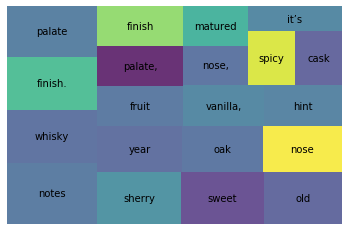

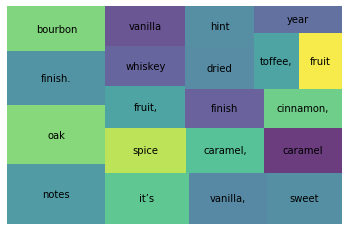

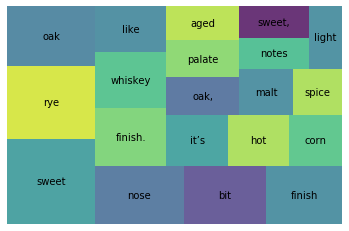

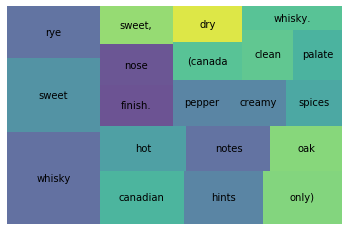

In [22]:
for wordset in [onec, twoc, threec, fourc]:
    top20 = wordset[wordset['rank'] <= 20]
    squarify.plot(sizes=top20['pct_total'], label=top20['word'], alpha=.8 )
    plt.axis('off')
    plt.show()

In [11]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
rfc = RandomForestClassifier()

In [12]:
# Define the Pipeline
pipe = Pipeline([
                 #Vectorizer
                 ('vect', vect),
                 # Classifier
                 ('clf', rfc)
                ])

# The pipeline puts together a bunch fit then transform,fit then predict. 

In [23]:
parameters = {
    'vect__max_df': (0.75, 0.9, 1.0),
    'vect__min_df': (0, .02, .05, .1),
    'vect__max_features': (500, 1000),
    'clf__n_estimators':(5, 10, 20),
    'clf__max_depth':(10, 20, 40)
}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(df['description'], df['category'])

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.75, 0.9, 1.0), 'vect__min_df': (0, 0.02, 0.05), 'vect__max_features': (500, 1000), 'clf__n_estimators': (5, 10, 20), 'clf__max_depth': (10, 20, 40)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [24]:
grid_search.best_score_

0.877030162412993

In [16]:
pred = grid_search.predict(test['description'])

In [17]:
submission = pd.DataFrame({'id': test['id'], 'category':pred})
submission['category'] = submission['category'].astype('int64')
submission.head()

,id,category
0,955,2
1,3532,3
2,1390,1
3,1024,1
4,1902,1


In [18]:
submission.to_csv('submission2.csv', index=False)